In [2]:
from networkx import add_path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os


# 2024 ward boundaries
ward_path = "../data/boundaries/ward boundaries 2024/london_wards_merged.shp"
wards = gpd.read_file(ward_path).to_crs("EPSG:4326")

base_dir = "../data/crime 2022-2025"

# Monthly burglary counts by ward
monthly_ward_counts = []

# Get all folder names
folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])

for folder in folders:
    for file in [f"{folder}-city-of-london-street.csv", f"{folder}-metropolitan-street.csv"]:
        path = os.path.join(base_dir, folder, file)
        if os.path.exists(path):
            print(f"Processing {path}")
            df = pd.read_csv(path, parse_dates=["Month"])
            
            # Filter for burglary crimes
            df = df[df["Crime type"].str.lower() == "burglary"]
            df = df.dropna(subset=["Latitude", "Longitude"])
            df["Month"] = pd.to_datetime(df["Month"]).dt.to_period("M").dt.to_timestamp()

            geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
            gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

            # Spatial join to match burglary points to ward polygons
            gdf = gpd.sjoin(gdf, wards, how="inner", predicate="intersects")

            # Group by month, ward name, and ward code
            counts = gdf.groupby(["Month", "WD24NM", "WD24CD"]).size().reset_index(name="burglary_count")

            # Rename for clarity
            counts.rename(columns={"WD24NM": "Ward name", "WD24CD": "Ward code"}, inplace=True)
            monthly_ward_counts.append(counts)


# Combine
df_monthly = pd.concat(monthly_ward_counts, ignore_index=True)

# Group before filling
df_monthly = df_monthly.groupby(["Month", "Ward name", "Ward code"], as_index=False).agg(
    {"burglary_count": "sum"}
)

# Create list to collect cleaned data per ward
filled_ward_data = []

# List of all months in the dataset (36 months)
all_months = pd.date_range(
    start=df_monthly["Month"].min(), 
    end=df_monthly["Month"].max(), 
    freq="MS"
)

# Loop over each ward
for (ward_name, ward_code), group in df_monthly.groupby(["Ward name", "Ward code"]):
    # Set Month as index and reindex to fill missing months
    ward_df = group.set_index("Month").reindex(all_months, fill_value=0)
    
    # Restore columns
    ward_df = ward_df.reset_index().rename(columns={"index": "Month"})
    ward_df["Ward name"] = ward_name
    ward_df["Ward code"] = ward_code
    
    filled_ward_data.append(ward_df)

# Combine everything
df_monthly = pd.concat(filled_ward_data, ignore_index=True)

# Final sort
df_monthly.sort_values(by="Month", inplace=True)

# Save result
output_path = "../data/processed/monthly_burglary_per_ward.csv"
df_monthly.to_csv(output_path, index=False)
print(f"\nSaved monthly burglary counts to: {output_path}")

Processing ../data/crime 2022-2025\2022-04\2022-04-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-04\2022-04-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-05\2022-05-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-05\2022-05-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-06\2022-06-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-06\2022-06-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-07\2022-07-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-07\2022-07-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-08\2022-08-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-08\2022-08-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-09\2022-09-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-09\2022-09-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-10\2022-10-city-of-london-street.csv
Processing 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load preprocessed burglary data
df = pd.read_csv("../data/processed/monthly_burglary_per_ward.csv", parse_dates=["Month"])

# Get list of unique wards
wards = df[["Ward name", "Ward code"]].drop_duplicates()

# Collect forecasts
all_forecasts = []

for _, row in wards.iterrows():
    ward_name = row["Ward name"]
    ward_code = row["Ward code"]
    
    # Filter and prepare time series
    ward_ts = df[(df["Ward name"] == ward_name) & (df["Ward code"] == ward_code)]
    ward_ts = ward_ts.set_index("Month").sort_index()

    # Fit SARIMA model
    model = SARIMAX(
        ward_ts["burglary_count"],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    try:
        results = model.fit(disp=False)
    except Exception as e:
        continue

    # Forecast next 3 months from the last available month
    last_month = ward_ts.index.max()
    future_months = pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=3, freq="MS")
    
    forecast = results.get_forecast(steps=3)
    forecast_df = forecast.summary_frame()
    forecast_df["Month"] = future_months
    forecast_df["Ward name"] = ward_name
    forecast_df["Ward code"] = ward_code

    # Select only necessary columns
    all_forecasts.append(forecast_df[["Month", "Ward name", "Ward code", "mean", "mean_ci_lower", "mean_ci_upper"]])

# Cxombine and Save
df_forecast_all = pd.concat(all_forecasts, ignore_index=True)
df_forecast_all.to_csv("../data/processed/sarima_forecast_all_wards.csv", index=False)

print(" Forecasts saved to: sarima_forecast_all_wards.csv")

C:\Users\20234582\CBL---data-science-project\venvv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20234582\CBL---data-science-project\venvv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20234582\CBL---data-science-project\venvv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\20234582\CBL---data-science-project\venvv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

 Forecasts saved to: sarima_forecast_all_wards.csv


Example forecast for one ward:

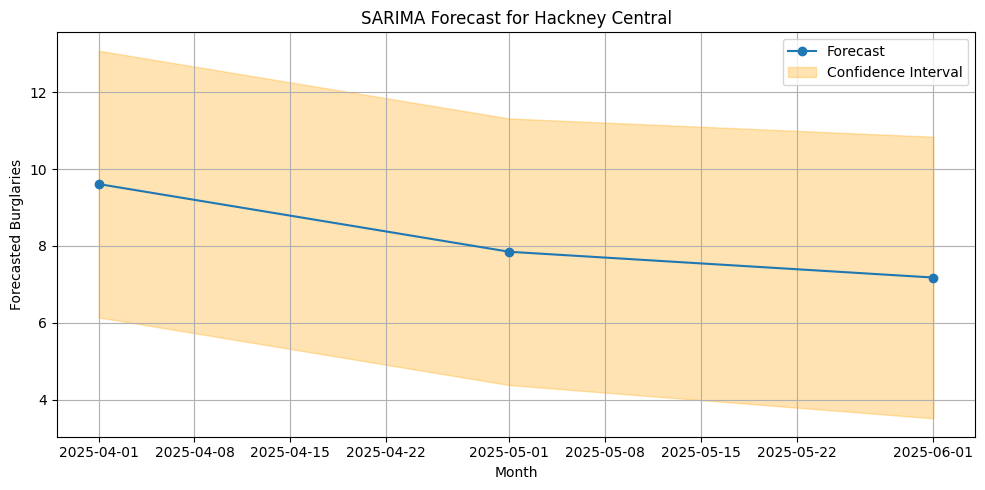

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved forecast
df_forecast = pd.read_csv("../data/processed/sarima_forecast_all_wards.csv", parse_dates=["Month"])

# Choose one ward to visualize
WARD_NAME = "Hackney Central"

# Filter the forecast
ward_forecast = df_forecast[df_forecast["Ward name"] == WARD_NAME]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(ward_forecast["Month"], ward_forecast["mean"], marker='o', label="Forecast")
plt.fill_between(ward_forecast["Month"], 
                 ward_forecast["mean_ci_lower"], 
                 ward_forecast["mean_ci_upper"], 
                 color="orange", alpha=0.3, label="Confidence Interval")
plt.title(f"SARIMA Forecast for {WARD_NAME}")
plt.xlabel("Month")
plt.ylabel("Forecasted Burglaries")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Load the monthly burglary data
df = pd.read_csv("../data/processed/monthly_burglary_per_ward.csv", parse_dates=["Month"])

tuning_path = "../data/processed/sarima_tuning_results.csv"

# Set up default and Grid-search parameters
test_months = 4 # hold out the last 4 months for evaluation
default_order = (1, 1, 1)
default_seasonal = (1, 1, 1, 12)

# p,d,q in {0,1} and P,D,Q in {0,1}, with seasonal period = 12
p = d = q = [0, 1]
P = D = Q = [0, 1]
s = 12

results = []
wards = df[["Ward name", "Ward code"]].drop_duplicates()


# loop each ward
for _, row in wards.iterrows():
    ward_name = row["Ward name"]
    ward_code = row["Ward code"]
    
    ts = df[(df["Ward name"] == ward_name) & (df["Ward code"] == ward_code)]
    ts = ts.sort_values("Month").set_index("Month")["burglary_count"]
    
    ts = ts.resample("M").sum().fillna(0)

    if len(ts) < 24:
        continue
    
    # Split into training vs test (last 4 months as test)
    split_idx = -test_months
    train_ts = ts.iloc[:split_idx]
    test_ts = ts.iloc[split_idx:]
    
    #Fit and evaluate the default SARIMA(1,1,1)(1,1,1,12)
    try:
        model_def = SARIMAX(
            train_ts,
            order=default_order,
            seasonal_order=default_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res_def = model_def.fit(disp=False)
        pred_def = res_def.get_forecast(steps=test_months).predicted_mean
        rmse_def = np.sqrt(mean_squared_error(test_ts, pred_def))
    except:
        rmse_def = np.nan
    
    # Grid‐search SARIMA over p,d,q in{0,1}, P,D,Q in {0,1}
    best_rmse = np.inf
    best_params = None
    
    for pi in p:
        for di in d:
            for qi in q:
                for Pi in P:
                    for Di in D:
                        for Qi in Q:
                            try:
                                model = SARIMAX(
                                    train_ts,
                                    order=(pi, di, qi),
                                    seasonal_order=(Pi, Di, Qi, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                res = model.fit(disp=False)
                                forecast_vals = res.get_forecast(steps=test_months).predicted_mean
                                rmse = np.sqrt(mean_squared_error(test_ts, forecast_vals))
                                
                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_params = ((pi, di, qi), (Pi, Di, Qi, s))
                            except:
                                continue
    
    # Record results for this ward
    results.append({
        "Ward name":     ward_name,
        "Ward code":     ward_code,
        "Default_RMSE":  rmse_def,
        "Tuned_RMSE":    best_rmse,
        "Best_order":    best_params[0] if best_params else None,
        "Best_seasonal": best_params[1] if best_params else None,
        "Improvement":   (rmse_def - best_rmse) 
                          if (not np.isnan(rmse_def) and not np.isinf(best_rmse)) 
                          else np.nan
    })

# SAVE TUNING RESULTS TO CSV
results_df = pd.DataFrame(results).dropna(subset=["Default_RMSE", "Tuned_RMSE"])
results_df["Improvement"] = results_df["Default_RMSE"] - results_df["Tuned_RMSE"]
results_df.to_csv(tuning_path, index=False)
print(f"Saved tuning results to: {tuning_path}")

Saved tuning results to: ../data/processed/sarima_tuning_results.csv


In [6]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

#Load full burglary history and tuning results
df = pd.read_csv("../data/processed/monthly_burglary_per_ward.csv", parse_dates=["Month"])
tuning_df = pd.read_csv("../data/processed/sarima_tuning_results.csv")

#Forecast horizon
forecast_horizon = 3

all_forecasts = []
wards = df[["Ward name", "Ward code"]].drop_duplicates()

for _, row in wards.iterrows():
    ward_name = row["Ward name"]
    ward_code = row["Ward code"]
    
    # Extract entire history for this ward
    ward_ts = (
        df[(df["Ward name"] == ward_name) & (df["Ward code"] == ward_code)]
        .sort_values("Month")
        .set_index("Month")["burglary_count"]
    )
    
    # Look up tuned parameters
    tune_row = tuning_df[
        (tuning_df["Ward name"] == ward_name) & 
        (tuning_df["Ward code"] == ward_code)
    ]
    
    if tune_row.empty:
        # Fallback to default
        order = (1, 1, 1)
        seasonal = (1, 1, 1, 12)
    else:
        raw_order = tune_row["Best_order"].values[0]
        raw_seasonal = tune_row["Best_seasonal"].values[0]
        
        # If pandas read them as strings (e.g. "(1, 1, 1)"), strip and split
        if isinstance(raw_order, str):
            order = tuple(int(x) for x in raw_order.strip("() ").split(","))
        else:
            order = raw_order  # already a tuple
        
        if isinstance(raw_seasonal, str):
            seasonal = tuple(int(x) for x in raw_seasonal.strip("() ").split(","))
        else:
            seasonal = raw_seasonal  # already a tuple
    
    # Fit SARIMA on full series with the tuned parameters
    model = SARIMAX(
        ward_ts,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    #  Forecast the next `forecast_horizon` months
    last_month = ward_ts.index.max()
    future_months = pd.date_range(
        start=last_month + pd.offsets.MonthBegin(1),
        periods=forecast_horizon,
        freq="MS"
    )
    forecast_df = res.get_forecast(steps=forecast_horizon).summary_frame()
    forecast_df["Month"] = future_months
    forecast_df["Ward name"] = ward_name
    forecast_df["Ward code"] = ward_code
    
    all_forecasts.append(
        forecast_df[[
            "Month", 
            "Ward name", 
            "Ward code", 
            "mean", 
            "mean_ci_lower", 
            "mean_ci_upper"
        ]]
    )

# Combine and save final tuned forecasts
df_final = pd.concat(all_forecasts, ignore_index=True)
df_final.to_csv(
    "../data/processed/sarima_final_forecast_per_ward.csv", 
    index=False
)
print("Saved tuned SARIMA forecasts to: data/processed/sarima_final_forecast_per_ward.csv")


Saved tuned SARIMA forecasts to: data/processed/sarima_final_forecast_per_ward.csv


In [1]:
# Three‐month forecast with 95% confidence intervals
forecast_horizon = 3
last_month = ward_ts.index.max()
future_months = pd.date_range(
    start=last_month + pd.offsets.MonthBegin(1),
    periods=forecast_horizon,
    freq="MS"
)

fc = res.get_forecast(steps=forecast_horizon).summary_frame()
fc["Month"] = future_months

plt.figure(figsize=(10, 5))
plt.plot(ward_ts, label="History", color="lightgray")
plt.plot(fc["Month"], fc["mean"], label="Forecast", color="orange", marker="o")
plt.fill_between(
    fc["Month"],
    fc["mean_ci_lower"],
    fc["mean_ci_upper"],
    color="orange",
    alpha=0.3
)
plt.title(f"{ward_name}: 3-Month SARIMA Forecast with 95% CI")
plt.ylabel("Burglary Count")
plt.xlabel("Month")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'ward_ts' is not defined

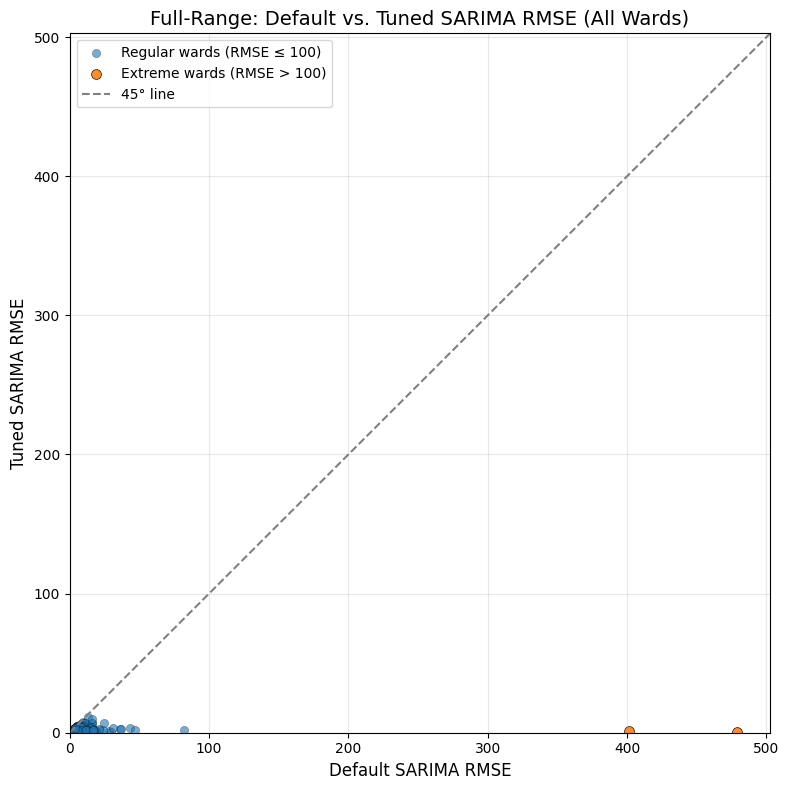

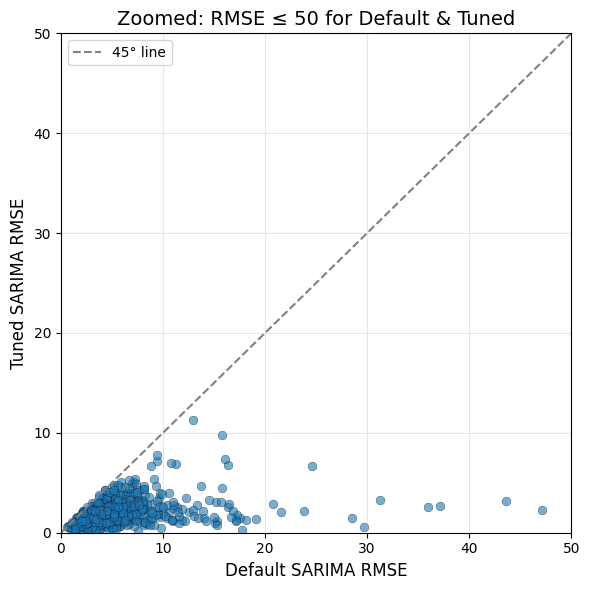

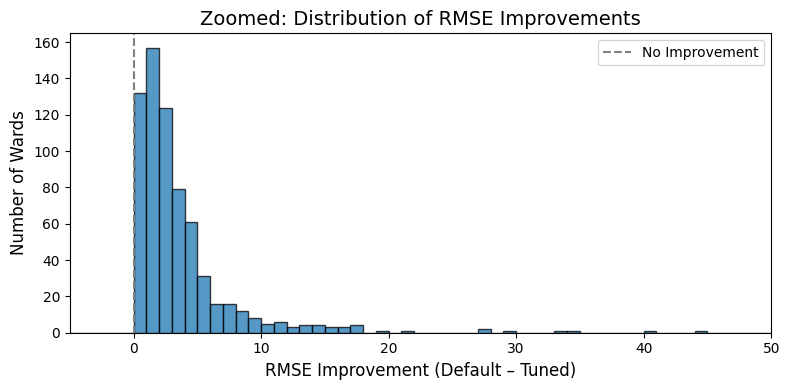

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Identify extreme outliers with Default_RMSE > 100 or Tuned_RMSE > 100
OUTLIER_THRESHOLD = 100
mask_outliers = (
    (results_df["Default_RMSE"] > OUTLIER_THRESHOLD) |
    (results_df["Tuned_RMSE"] > OUTLIER_THRESHOLD)
)
outliers = results_df[mask_outliers]
non_outliers = results_df[~mask_outliers]

max_full = results_df[["Default_RMSE", "Tuned_RMSE"]].max().max() * 1.05

plt.figure(figsize=(8, 8))
plt.scatter(
    non_outliers["Default_RMSE"],
    non_outliers["Tuned_RMSE"],
    alpha=0.6,
    s=35,
    edgecolor="k",
    linewidth=0.3,
    label=f"Regular wards (RMSE ≤ {OUTLIER_THRESHOLD})"
)
# Outliers (next color in the default cycle)
plt.scatter(
    outliers["Default_RMSE"],
    outliers["Tuned_RMSE"],
    alpha=0.9,
    s=50,
    edgecolor="k",
    linewidth=0.5,
    label=f"Extreme wards (RMSE > {OUTLIER_THRESHOLD})"
)

# Draw the 45° reference line
plt.plot([0, max_full], [0, max_full], "--", color="gray", label="45° line")

plt.xlim(0, max_full)
plt.ylim(0, max_full)
plt.xlabel("Default SARIMA RMSE", fontsize=12)
plt.ylabel("Tuned SARIMA RMSE", fontsize=12)
plt.title("Full‐Range: Default vs. Tuned SARIMA RMSE (All Wards)", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Zoomed‐in scatter for the majority of wards (RMSE ≤ 50)
ZOOM_LIMIT = 50
zoom_mask = (
    (results_df["Default_RMSE"] <= ZOOM_LIMIT) &
    (results_df["Tuned_RMSE"]   <= ZOOM_LIMIT)
)
zoom_df = results_df[zoom_mask]

plt.figure(figsize=(6, 6))
plt.scatter(
    zoom_df["Default_RMSE"],
    zoom_df["Tuned_RMSE"],
    alpha=0.6,
    s=40,
    edgecolor="k",
    linewidth=0.3
)

# 45° reference line in zoomed plot
plt.plot([0, ZOOM_LIMIT], [0, ZOOM_LIMIT], "--", color="gray", label="45° line")

plt.xlim(0, ZOOM_LIMIT)
plt.ylim(0, ZOOM_LIMIT)
plt.xlabel("Default SARIMA RMSE", fontsize=12)
plt.ylabel("Tuned SARIMA RMSE", fontsize=12)
plt.title(f"Zoomed: RMSE ≤ {ZOOM_LIMIT} for Default & Tuned", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Histogram of improvements (Default_RMSE - Tuned_RMSE)
improvements = results_df["Default_RMSE"] - results_df["Tuned_RMSE"]

plt.figure(figsize=(8, 4))
plt.hist(improvements, bins=np.arange(-5, 51, 1), edgecolor="k", alpha=0.75)
plt.axvline(0, color="gray", linestyle="--", label="No Improvement")
plt.xlim(-5, 50)
plt.xlabel("RMSE Improvement (Default – Tuned)", fontsize=12)
plt.ylabel("Number of Wards", fontsize=12)
plt.title("Zoomed: Distribution of RMSE Improvements", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

results_df = pd.read_csv("../data/processed/sarima_tuning_results.csv")

# Compute average RMSE across all wards
avg_default_rmse = results_df["Default_RMSE"].mean()
avg_tuned_rmse   = results_df["Tuned_RMSE"].mean()
avg_improvement  = (results_df["Default_RMSE"] - results_df["Tuned_RMSE"]).mean()

print(f"Average Default SARIMA RMSE: {avg_default_rmse:.2f}")
print(f"Average Tuned SARIMA RMSE: {avg_tuned_rmse:.2f}")
print(f"Average Improvement: {avg_improvement:.2f}")


Average Default SARIMA RMSE: 6.99
Average Tuned SARIMA RMSE: 1.99
Average Improvement: 5.00


In [14]:
# STORE THE CHARTS FOR DASHBOARD DISPLAY

import os
import json
import plotly.graph_objects as go

output_dir = "assets/forecast_charts"
os.makedirs(output_dir, exist_ok=True)

for _, row in wards.iterrows():
    ward_name = row["Ward name"]
    ward_code = row["Ward code"]
    
    ward_ts = (
        df[(df["Ward name"] == ward_name) & (df["Ward code"] == ward_code)]
        .sort_values("Month")
        .set_index("Month")["burglary_count"]
    )
    
    tune_row = tuning_df[
        (tuning_df["Ward name"] == ward_name) &
        (tuning_df["Ward code"] == ward_code)
    ]
    
    if tune_row.empty:
        order = (1, 1, 1)
        seasonal = (1, 1, 1, 12)
    else:
        raw_order = tune_row["Best_order"].values[0]
        raw_seasonal = tune_row["Best_seasonal"].values[0]
        order = tuple(int(x) for x in str(raw_order).strip("() ").split(","))
        seasonal = tuple(int(x) for x in str(raw_seasonal).strip("() ").split(","))
    
    model = SARIMAX(
        ward_ts,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    fc = res.get_forecast(steps=forecast_horizon).summary_frame()
    last_month = ward_ts.index.max()
    future_months = pd.date_range(
        start=last_month + pd.offsets.MonthBegin(1),
        periods=forecast_horizon,
        freq="MS"
    )
    fc["Month"] = future_months

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ward_ts.index, y=ward_ts, mode="lines", name="History", line=dict(color="lightgray")))
    fig.add_trace(go.Scatter(x=fc["Month"], y=fc["mean"], mode="lines+markers", name="Forecast", line=dict(color="orange")))
    fig.add_trace(go.Scatter(
        x=fc["Month"],
        y=fc["mean_ci_upper"],
        mode="lines",
        name="Upper CI",
        line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=fc["Month"],
        y=fc["mean_ci_lower"],
        mode="lines",
        name="Lower CI",
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(255,165,0,0.3)',
        showlegend=False
    ))

    fig.update_layout(
        title=f"{ward_name} ({ward_code}): 3-Month SARIMA Forecast",
        xaxis_title="Month",
        yaxis_title="Burglary Count",
        template="plotly_white"
    )

    # Save figure as JSON
    fig_path = os.path.join(output_dir, f"{ward_code}_forecast.json")
    with open(fig_path, "w") as f:
        f.write(fig.to_json())
